# SVM的SMO代码解析

[SMO算法原理](https://www.cnblogs.com/pinard/p/6111471.html)            
[SVM算法手推](./svm.pdf)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from copy import deepcopy

定义核函数

In [19]:
def kernel(x: np.ndarray, z: np.ndarray, sigma: float = 0.5):
    return np.exp(-np.linalg.norm(x-z, ord=2) ** 2 / (2 * sigma ** 2))

定义$g(x_i)$, 并提前计算好 $g(x_i), e(x_i)$存储在列表中

$$
g(x_i) = \sum_{j=1}^N \alpha_j y_j K(x_i, x_j) + b \\
E_i = g(x_i) - y_i
$$

In [20]:
class SVM:
    def __init__(self, c: float, max_iter: int = 1000):
        self.c = c
        self.b = 0.0
        self.max_iter = max_iter
    
    def _init_param(self, X, y):
        self.X = X
        self.y = y
        self.n = y.shape[0]
        self.alpha = np.zeros(self.n)
        self.g = [self.compute_g(i) for i in range(self.n)]
        self.e = [self.g[i] - self.y[i] for i in range(self.n)]
        
    def compute_g(self, i: int):
        res = self.b
        for j in range(self.n):
            res += self.alpha[j] * self.y[j] * kernel(self.X[j], self.X[i])

        return res

选择优化变量 $\alpha_i, \alpha_j$           
1. $\alpha_i$的选择: 最违反KKT条件的变量, 即$E_i$最大的下标         
2. $\alpha_j$的选择: 使得$|E_j - E_i|$最大的下标j, 如果没有, 则随机选择一个         

In [21]:
def select_alpha_ij(self):
    i, max_violation = -1, 0
    for idx in range(self.n):
        if (0 < self.alpha[idx] < self.c) or (self.alpha[idx] == 0 or self.alpha[idx] == self.c):
            violation = abs(self.e[idx])
            if violation > max_violation:
                max_violation = violation
                i = idx

    # 已经收敛
    if i == -1:
        return -1, -1

    j, max_delta = -1, 0
    for idx in range(self.n):
        if idx == i:
            continue
        delta = abs(self.e[i] - self.e[idx])
        if delta > max_delta:
            max_delta = delta
            j = idx

    # 没有找到合适的j则随机选择一个
    if j == -1:
        import random
        j = random.choice([k for k in range(self.n) if k != j])

    return i, j

setattr(SVM, 'select_alpha_ij', select_alpha_ij)

更新$\alpha_i, \alpha_j$, 更新的方式可以参照《统计学习方法》书中的算法流程, 这里就不多赘述, 直接上代码

In [22]:
def train(self, X: np.ndarray, y: np.ndarray):
    self._init_param(X, y)

    for _ in range(self.max_iter):
        i, j = self.select_alpha_ij()
        if i == -1:  # 所有的alpha均满足KKT条件
            break

        self.update(i, j)

def update(self, i: int, j: int):
    alpha1_old = deepcopy(self.alpha[i])
    alpha2_old = deepcopy(self.alpha[j])
    if self.y[i] == self.y[j]:
        L = max(0, alpha2_old+alpha1_old-self.c)
        H = min(self.c, alpha2_old+alpha1_old)
    else:
        L = max(0, alpha2_old-alpha1_old)
        H = min(self.c, self.c+alpha2_old-alpha1_old)
    eta = kernel(self.X[i], self.X[i]) + kernel(self.X[j],
                                                self.X[j]) - 2 * kernel(self.X[i], self.X[j])
    if eta <= 0:
        return

    alpha2_new = alpha2_old + self.y[j] * (self.e[i] - self.e[j]) / eta
    if alpha2_new > H:
        alpha2_new = H
    elif alpha2_new < L:
        alpha2_new = L
    alpha1_new = alpha1_old + self.y[i] * self.y[j] * (alpha2_old-alpha2_new)
    self.alpha[i] = alpha1_new
    self.alpha[j] = alpha2_new

    b1_new = -self.e[i] - self.y[i] * kernel(self.X[i], self.X[i]) * (alpha1_new-alpha1_old) - \
        self.y[j]*kernel(self.X[j], self.X[i])*(alpha2_new-alpha2_old) + self.b
    b2_new = -self.e[j] - self.y[i] * kernel(self.X[i], self.X[j]) * (
        alpha1_new-alpha1_old) - self.y[j] * kernel(self.X[j], self.X[j]) * (alpha2_new-alpha2_old) + self.b

    if 0 < alpha1_new < self.c:
        self.b = b1_new
    elif 0 < alpha2_new < self.c:
        self.b = b2_new
    else:
        self.b = (b1_new + b2_new) / 2.0

    # 更新E_i
    for i in range(self.n):
        self.e[i] = self.b - self.y[i]
        for j in range(self.n):
            if self.alpha[j] > 0:  # 支持向量
                self.e[i] += self.y[j] * self.alpha[j] * kernel(self.X[i], self.X[j])

def predict(self, X: np.ndarray):
    y_pred = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        prediction = np.sum(self.alpha * self.y *
                            np.array([kernel(X[i], self.X[j]) for j in range(len(self.X))])) + self.b
        y_pred[i] = np.sign(prediction)

    return y_pred

setattr(SVM, 'train', train)
setattr(SVM, 'update', update)
setattr(SVM, 'predict', predict)

数据集验证

Test Accuracy: 1.0000


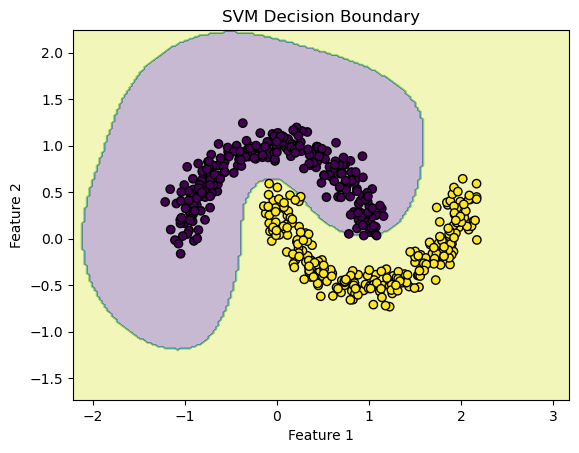

In [23]:
def plot_decision_boundary(model: SVM, X: np.ndarray, y: np.ndarray):
    """ 可视化决策边界 """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# 生成数据集
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
y = np.where(y == 0, -1, 1)

# 训练测试集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVM(c=1.0, max_iter=200)
model.train(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_decision_boundary(model, X, y)